In [82]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import numpy as np
import os
from pipeline import Pipeline
from utils import Map, show_image_gray, warp_image
from find_lanes import ConvolutionLaneFinder

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
fname = 'test_images/test2.jpg'
args = Map({'filename': fname})

In [170]:
pipeline = Pipeline(args)

Loading 'test_images/test2.jpg'
Loading threshold parameters...
Loading camera calibration parameters...


In [153]:
M, M_inv = Pipeline.load_perspective_transform()

In [154]:
image = pipeline.undistorted_image
imshape = image.shape

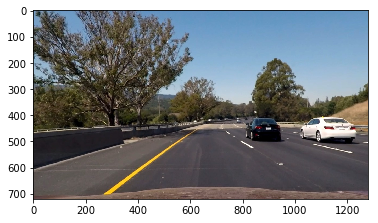

In [155]:
plt.imshow(image)

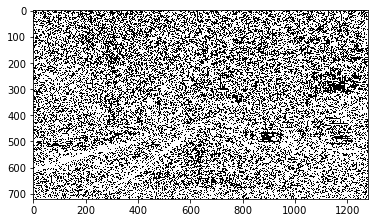

In [156]:
binary = pipeline.apply_thresholing(image)

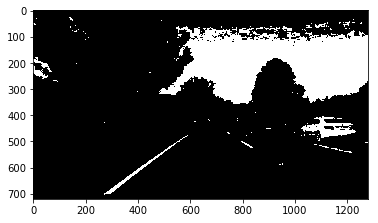

In [157]:
show_image_gray(binary)

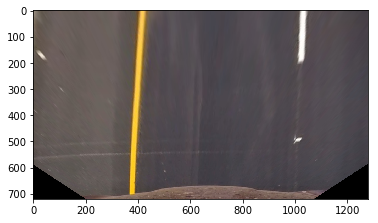

In [158]:
warped = warp_image(image, M); plt.imshow(warped)

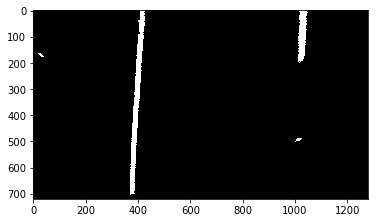

In [159]:
binary_warped = warp_image(binary, M); show_image_gray(binary_warped)

# Finding lanes

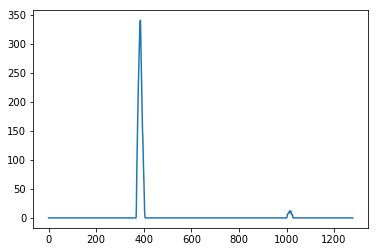

In [160]:
hist = np.sum(binary_warped[imshape[0]//2:,:], axis=0); plt.plot(hist)

In [161]:
midpoint = hist.shape[0]//2
left_base = np.argmax(hist[:midpoint])
right_base = np.argmax(hist[midpoint:]) + midpoint
out_img = np.dstack([binary_warped, binary_warped, binary_warped]) * 255
n_windows = 9
window_height = imshape[0] // n_windows
margin = 100
minpix = 50

nonzero = binary_warped.nonzero()
nonzero_y = np.array(nonzero[0])
nonzero_x = np.array(nonzero[1])

left_lane_indices, right_lane_indices = [], []
leftx_current = left_base
rightx_current = right_base

In [162]:
for window in range(n_windows):
    window_y_low = imshape[0] - (window + 1) * window_height
    window_y_high = imshape[0] - window * window_height
    window_x_left_low = leftx_current - margin
    window_x_left_high = leftx_current + margin
    window_x_right_low = rightx_current - margin
    window_x_right_high = rightx_current + margin
    
    cv2.rectangle(out_img,(window_x_left_low, window_y_low), (window_x_left_high, window_y_high), (0, 255, 0), 2)
    cv2.rectangle(out_img,(window_x_right_low, window_y_low), (window_x_right_high, window_y_high), (0, 255, 0), 2)
    
    left_indices = ((nonzero_y >= window_y_low) & (nonzero_y < window_y_high) & 
     (nonzero_x >= window_x_left_low) & (nonzero_x <= window_x_left_high)).nonzero()[0]
    right_indices = ((nonzero_y >= window_y_low) & (nonzero_y < window_y_high) & 
     (nonzero_x >= window_x_right_low) & (nonzero_x <= window_x_right_high)).nonzero()[0]
        
    left_lane_indices.append(left_indices)
    right_lane_indices.append(right_indices)
    
    if (len(left_indices) > minpix):
        leftx_current = np.int(np.mean(nonzero_x[left_indices]))
    if (len(right_indices) > minpix):
        rightx_current = np.int(np.mean(nonzero_x[right_indices]))

In [163]:
left_lane_indices = np.concatenate(left_lane_indices)
right_lane_indices = np.concatenate(right_lane_indices)

leftx = nonzero_x[left_lane_indices]
lefty = nonzero_y[left_lane_indices]
rightx = nonzero_x[right_lane_indices]
righty = nonzero_y[right_lane_indices]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

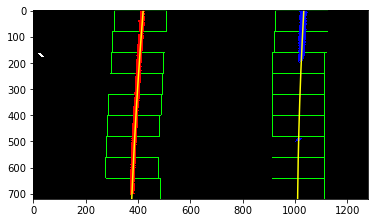

In [164]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
out_img[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]

fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.imshow(out_img)
ax.plot(left_fitx, ploty, color='yellow')
ax.plot(right_fitx, ploty, color='yellow')

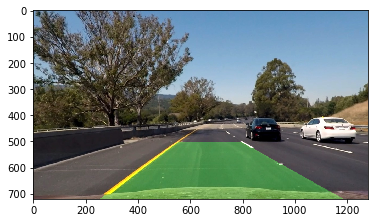

In [165]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [166]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level + 1) * height):int(img_ref.shape[0] - level * height),
    max(0, int(center - width / 2)):min(int(center + width / 2), img_ref.shape[1])] = 1
    return output

In [167]:
warped = binary_warped

# window settings
window_width = 50
window_height = 80  # Break image into 9 vertical layers since image height is 720
margin = 100  # How much to slide left and right for searching

y, x = warped.shape

window_centroids = []

window = np.ones(window_width)

l_sum = np.sum(warped[int(3 * y / 4):, :int(x / 2)], axis=0)
l_center = np.argmax(np.convolve(window, l_sum)) - window_width / 2

r_sum = np.sum(warped[int(3 * y / 4):, int(x / 2):], axis=0)
r_center = np.argmax(np.convolve(window, r_sum)) - window_width / 2 + int(x / 2)

window_centroids.append((l_center, r_center))

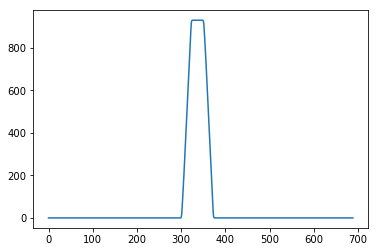

In [132]:
y, x, _ = imshape
plt.plot(np.convolve(window, r_sum))

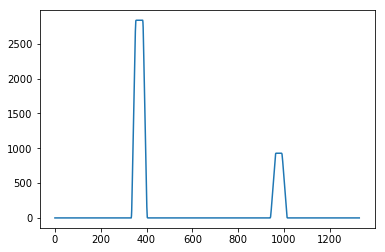

In [133]:
plt.plot(np.convolve(window, np.sum(warped[int(3*y/4):], axis=0)))

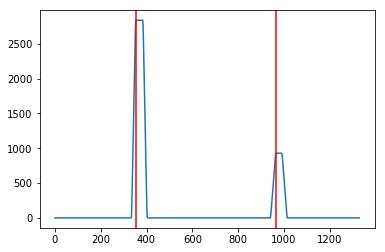

In [134]:
s = np.sum(warped[int(3 * y / 4):], axis=0)
plt.plot(np.convolve(window, s))
plt.axvline(x=l_center + int(window_width/2), color='red')
plt.axvline(x=r_center + int(window_width/2), color='red')

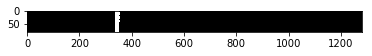

In [135]:
show_image_gray(warped[int(y - 2*window_height):int(y - window_height)])

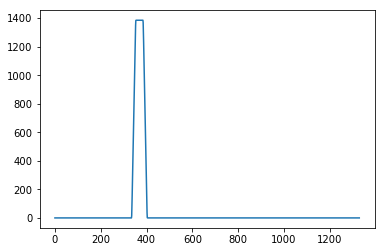

In [136]:
image_layer = np.sum(warped[int(y - 2*window_height):int(y - window_height)], axis=0)
conv_signal = np.convolve(window, image_layer)
plt.plot(conv_signal)

In [137]:
r_min_index = int(max(r_center - offset - margin, 0))
r_max_index = int(min(r_center + offset + margin, x))

In [143]:
r_min_index, r_max_index, r_center

(815, 1065, 940.0)

In [142]:
np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset

790.0

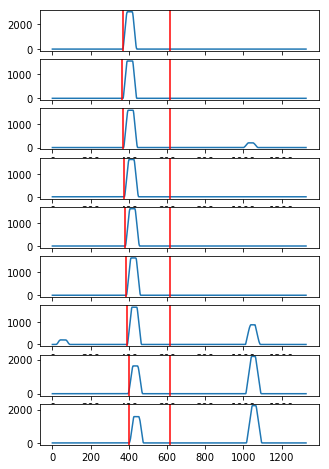

In [168]:
fig, ax = plt.subplots(nrows=int(warped.shape[0]/window_height),ncols=1)
fig.set_size_inches(5, 8)

conv_signal = np.convolve(window, np.sum(warped[int(3*y/4):], axis=0))
ax[0].plot(conv_signal)
ax[0].axvline(x=l_center, color='red')
ax[0].axvline(x=r_center, color='red')

for level in range(1, int(warped.shape[0] / window_height)):
    image_layer = np.sum(
        warped[int(y - (level + 1) * window_height):int(y - level * window_height),:], axis=0)
    conv_signal = np.convolve(window, image_layer)

    offset = window_width / 2
    l_min_index = int(max(l_center - offset - margin, 0))
    l_max_index = int(min(l_center + offset + margin, warped.shape[1]))
    l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset

    r_min_index = int(max(r_center - offset - margin, 0))
    r_max_index = int(min(r_center + offset + margin, warped.shape[1]))
    if np.max(conv_signal[r_min_index:r_max_index]) > 0:
        r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset

    window_centroids.append((l_center, r_center))
    
    ax[level].plot(conv_signal)
    ax[level].axvline(x=l_center, color='red')
    ax[level].axvline(x=r_center, color='red')